# Imports

In [190]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

import optuna

## Functions

In [191]:
def ml_metrics(y_val, y_pred, model_name, k): 
    acc       = mt.accuracy_score(y_val, y_pred)
    precision = mt.precision_score(y_val, y_pred)
    recall    = mt.recall_score(y_val, y_pred)
    f1_score  = mt.f1_score(y_val, y_pred)
    df_results = pd.DataFrame( {'Model':[model_name],
                                'K': [k],
                                'Accuracy': [acc],
                                'Precision': [precision],
                                'Recall': [recall],
                                'F1-Score': [f1_score]})
    
    return df_results

# Carregando Dados

In [192]:
# Dados de Treino
X_train = pd.read_csv('datasets/classificacao/X_training.csv')
y_train = pd.read_csv('datasets/classificacao/y_training.csv').values.ravel()

# Dados de Validação
X_val = pd.read_csv('datasets/classificacao/X_validation.csv')
y_val = pd.read_csv('datasets/classificacao/y_validation.csv').values.ravel()

# Dados de Teste
X_test = pd.read_csv('datasets/classificacao/X_test.csv')
y_test = pd.read_csv('datasets/classificacao/y_test.csv').values.ravel()

In [193]:
print(f'Dados de Treino:    Linhas: {X_train.shape[0]}   Colunas: {X_train.shape[1]}')
print(f'Dados de Validação: Linhas: {X_val.shape[0]}   Colunas: {X_val.shape[1]}')
print(f'Dados de Teste:     Linhas: {X_test.shape[0]}   Colunas: {X_test.shape[1]}')

Dados de Treino:    Linhas: 72515   Colunas: 25
Dados de Validação: Linhas: 31079   Colunas: 25
Dados de Teste:     Linhas: 25893   Colunas: 25


# Ensaio

Métricas do Ensaio:

- Accuracy
- Precision
- Recall
- F1-Score

## KNN

### Predict with Fine Tuning

In [219]:
knn_results = pd.DataFrame()
for k in range(3, 30,2):
    # model definition
    knn_model = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    
    # model fit
    knn_model.fit(X_train, y_train)
    
    # model predict
    y_pred = knn_model.predict(X_val)
    
    # metrics
    k_results = ml_metrics(y_val, y_pred, 'KNN', k)
    
    # saving results
    knn_results = pd.concat([knn_results, k_results], axis=0)

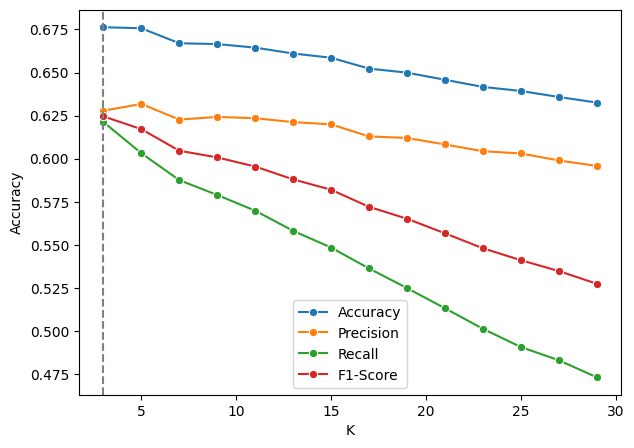

In [220]:
plt.figure(figsize=(7,5))
sns.lineplot(x = 'K', y = 'Accuracy', data=knn_results, marker='o', label='Accuracy')
sns.lineplot(x = 'K', y = 'Precision', data=knn_results, marker='o', label='Precision')
sns.lineplot(x = 'K', y = 'Recall', data=knn_results, marker='o', label='Recall')
sns.lineplot(x = 'K', y = 'F1-Score', data=knn_results, marker='o', label='F1-Score');

k_max = knn_results.loc[knn_results['F1-Score'] == knn_results['F1-Score'].max(), 'K'][0]
plt.axvline(x=k_max, color='gray',linestyle='--');

### Best Parameters

In [196]:
knn_best_params = {'k':3}

## Decision Tree

### Training with Fine Tuning

In [197]:
dt_results = pd.DataFrame()
for md in range(2, 50):
    dt_model = DecisionTreeClassifier(max_depth=md)
    
    dt_model.fit(X_train, y_train)
    
    y_pred = dt_model.predict(X_val)
    
    i_results = ml_metrics(y_val, y_pred, 'Decision Tree', md)
    
    dt_results = pd.concat([dt_results,i_results], axis=0)

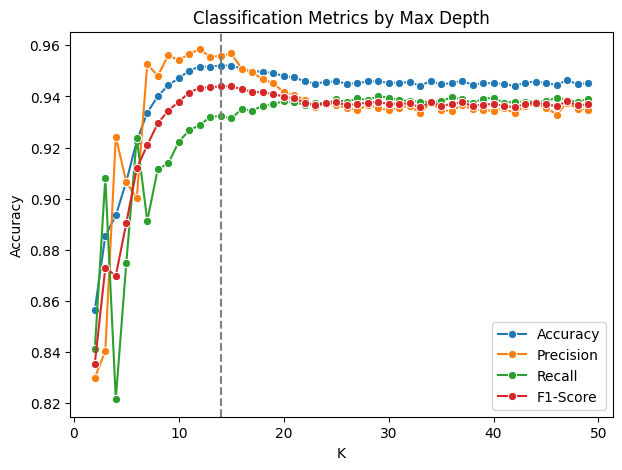

In [198]:
plt.figure(figsize=(7,5))
plt.title('Classification Metrics by Max Depth')
sns.lineplot(x = 'K', y = 'Accuracy',  data=dt_results, marker='o', label='Accuracy')
sns.lineplot(x = 'K', y = 'Precision', data=dt_results, marker='o', label='Precision')
sns.lineplot(x = 'K', y = 'Recall',    data=dt_results, marker='o', label='Recall')
sns.lineplot(x = 'K', y = 'F1-Score',  data=dt_results, marker='o', label='F1-Score');

k_max = dt_results.loc[dt_results['F1-Score'] == dt_results['F1-Score'].max(), 'K'][0]
plt.axvline(x=k_max, color='gray',linestyle='--');

### Best Params

In [199]:
dt_best_params = {'max_depth':13}

## Random Forest

### Training with Fine Tuning

In [200]:
def rf_fine_tuning(trial):
    n_estimators = trial.suggest_int('n_estimators', 5, 30)
    max_depth = trial.suggest_int('max_depth', 5, 30)

    rf_model = RandomForestClassifier(n_estimators = n_estimators, max_depth=max_depth)

    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_val)

    return mt.f1_score(y_val, y_pred)

In [201]:
study = optuna.create_study(direction='maximize')
study.optimize(rf_fine_tuning, n_trials=100)

[I 2023-08-19 17:58:11,653] A new study created in memory with name: no-name-5a85542d-20ff-494f-adfc-c8705a4e2209
[I 2023-08-19 17:58:15,779] Trial 0 finished with value: 0.9561192232425109 and parameters: {'n_estimators': 29, 'max_depth': 30}. Best is trial 0 with value: 0.9561192232425109.
[I 2023-08-19 17:58:17,169] Trial 1 finished with value: 0.9514708637811504 and parameters: {'n_estimators': 9, 'max_depth': 27}. Best is trial 0 with value: 0.9561192232425109.
[I 2023-08-19 17:58:17,805] Trial 2 finished with value: 0.9254802302115255 and parameters: {'n_estimators': 7, 'max_depth': 7}. Best is trial 0 with value: 0.9561192232425109.
[I 2023-08-19 17:58:19,539] Trial 3 finished with value: 0.941919476711402 and parameters: {'n_estimators': 15, 'max_depth': 10}. Best is trial 0 with value: 0.9561192232425109.
[I 2023-08-19 17:58:21,035] Trial 4 finished with value: 0.9516135134112662 and parameters: {'n_estimators': 10, 'max_depth': 30}. Best is trial 0 with value: 0.9561192232425

[I 2023-08-19 18:00:45,649] Trial 45 finished with value: 0.9574067093856011 and parameters: {'n_estimators': 30, 'max_depth': 25}. Best is trial 30 with value: 0.9575487717444624.
[I 2023-08-19 18:00:49,285] Trial 46 finished with value: 0.9553544494720967 and parameters: {'n_estimators': 25, 'max_depth': 21}. Best is trial 30 with value: 0.9575487717444624.
[I 2023-08-19 18:00:53,253] Trial 47 finished with value: 0.9572122078801791 and parameters: {'n_estimators': 27, 'max_depth': 27}. Best is trial 30 with value: 0.9575487717444624.
[I 2023-08-19 18:00:56,480] Trial 48 finished with value: 0.9553803794365028 and parameters: {'n_estimators': 22, 'max_depth': 25}. Best is trial 30 with value: 0.9575487717444624.
[I 2023-08-19 18:00:58,722] Trial 49 finished with value: 0.9556257521058964 and parameters: {'n_estimators': 15, 'max_depth': 27}. Best is trial 30 with value: 0.9575487717444624.
[I 2023-08-19 18:01:03,059] Trial 50 finished with value: 0.9557069205584616 and parameters: {'

[I 2023-08-19 18:03:39,894] Trial 91 finished with value: 0.9562985885727225 and parameters: {'n_estimators': 30, 'max_depth': 27}. Best is trial 72 with value: 0.958452506397712.
[I 2023-08-19 18:03:43,920] Trial 92 finished with value: 0.9566035605404795 and parameters: {'n_estimators': 29, 'max_depth': 26}. Best is trial 72 with value: 0.958452506397712.
[I 2023-08-19 18:03:48,180] Trial 93 finished with value: 0.9579439252336448 and parameters: {'n_estimators': 30, 'max_depth': 25}. Best is trial 72 with value: 0.958452506397712.
[I 2023-08-19 18:03:52,781] Trial 94 finished with value: 0.9564036807965003 and parameters: {'n_estimators': 30, 'max_depth': 27}. Best is trial 72 with value: 0.958452506397712.
[I 2023-08-19 18:03:56,991] Trial 95 finished with value: 0.9576795413397707 and parameters: {'n_estimators': 28, 'max_depth': 25}. Best is trial 72 with value: 0.958452506397712.
[I 2023-08-19 18:04:01,370] Trial 96 finished with value: 0.9571960998381207 and parameters: {'n_est

In [202]:
optuna.visualization.plot_optimization_history(study)

### Best Parameters

In [203]:
rf_best_params = study.best_params
rf_best_params

{'n_estimators': 29, 'max_depth': 28}

## Logistic Regression

### Training with Fine Tuning

In [204]:
def lg_fine_tuning(trial):
    C = trial.suggest_float('C', 0, 2)
    solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'])
    max_iter = trial.suggest_int('max_iter', 300, 500)

    lg_model = LogisticRegression(C = C, solver=solver, max_iter=max_iter)

    lg_model.fit(X_train, y_train)

    y_pred = lg_model.predict(X_val)

    return mt.f1_score(y_val, y_pred)

In [205]:
study = optuna.create_study(direction='maximize')
study.optimize(lg_fine_tuning, n_trials=100)

[I 2023-08-19 18:04:17,128] A new study created in memory with name: no-name-d8068b5c-306a-43ff-9914-a2be4511bccd
C:\Users\Notebook\anaconda3\envs\f_machine_learning_env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

[I 2023-08-19 18:04:34,705] Trial 0 finished with value: 0.010169491525423728 and parameters: {'C': 0.32663271513485226, 'solver': 'saga', 'max_iter': 392}. Best is trial 0 with value: 0.010169491525423728.
C:\Users\Notebook\anaconda3\envs\f_machine_learning_env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

[I 2023-08-19 18:04:54,248] Trial 1 finished with value: 0.01221486387049301 and parameters: {'C': 0.5136914690991157, 'solver': 'saga', 'max_iter': 448}. Best is trial 1 with value: 0.01221486387049301.
C:\Users\Notebook\anaconda3\envs\f_machine_learning_env\Lib\site-packages\sklearn\linea

C:\Users\Notebook\anaconda3\envs\f_machine_learning_env\Lib\site-packages\scipy\optimize\_linesearch.py:425: LineSearchWarning:

Rounding errors prevent the line search from converging

C:\Users\Notebook\anaconda3\envs\f_machine_learning_env\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning:

Line Search failed

[I 2023-08-19 18:06:40,732] Trial 18 finished with value: 0.8522654150422045 and parameters: {'C': 1.2405686774064315, 'solver': 'newton-cg', 'max_iter': 333}. Best is trial 13 with value: 0.8523411181346758.
C:\Users\Notebook\anaconda3\envs\f_machine_learning_env\Lib\site-packages\scipy\optimize\_linesearch.py:466: LineSearchWarning:

The line search algorithm did not converge

C:\Users\Notebook\anaconda3\envs\f_machine_learning_env\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning:

The line search algorithm did not converge

C:\Users\Notebook\anaconda3\envs\f_machine_learning_env\Lib\site-packages\scipy\optimize\_linesearch.py:425: LineSearchW

C:\Users\Notebook\anaconda3\envs\f_machine_learning_env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

[I 2023-08-19 18:08:38,239] Trial 30 finished with value: 0.011484944415813884 and parameters: {'C': 1.4418035265823963, 'solver': 'saga', 'max_iter': 432}. Best is trial 22 with value: 0.8524069028156221.
C:\Users\Notebook\anaconda3\envs\f_machine_learning_env\Lib\site-packages\scipy\optimize\_linesearch.py:466: LineSearchWarning:

The line search algorithm did not converge

C:\Users\Notebook\anaconda3\envs\f_machine_learning_env\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning:

The line search algorithm did not converge

C:\Users\Notebook\anaconda3\envs\f_machine_learning_env\Lib\site-packages\scipy\optimize\_linesearch.py:425: LineSearchWarning:

Rounding errors prevent the line search from converging

C:\Users\Notebook\anaconda3\envs\f_machine_learning_env\Lib\site-pac

[I 2023-08-19 18:10:51,293] Trial 43 finished with value: 0.0 and parameters: {'C': 1.7332857943405187, 'solver': 'lbfgs', 'max_iter': 469}. Best is trial 42 with value: 0.8524714253273786.
C:\Users\Notebook\anaconda3\envs\f_machine_learning_env\Lib\site-packages\scipy\optimize\_linesearch.py:466: LineSearchWarning:

The line search algorithm did not converge

C:\Users\Notebook\anaconda3\envs\f_machine_learning_env\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning:

The line search algorithm did not converge

C:\Users\Notebook\anaconda3\envs\f_machine_learning_env\Lib\site-packages\scipy\optimize\_linesearch.py:425: LineSearchWarning:

Rounding errors prevent the line search from converging

C:\Users\Notebook\anaconda3\envs\f_machine_learning_env\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning:

Line Search failed

[I 2023-08-19 18:11:02,586] Trial 44 finished with value: 0.8523088569265709 and parameters: {'C': 1.772430571536314, 'solver': 'newton-cg'

C:\Users\Notebook\anaconda3\envs\f_machine_learning_env\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning:

Line Search failed

[I 2023-08-19 18:12:46,179] Trial 55 finished with value: 0.8522107813446397 and parameters: {'C': 1.995875135215315, 'solver': 'newton-cg', 'max_iter': 342}. Best is trial 42 with value: 0.8524714253273786.
[I 2023-08-19 18:12:46,418] Trial 56 finished with value: 0.8522107813446397 and parameters: {'C': 1.8905822433789925, 'solver': 'newton-cholesky', 'max_iter': 487}. Best is trial 42 with value: 0.8524714253273786.
[I 2023-08-19 18:12:46,534] Trial 57 finished with value: 0.0 and parameters: {'C': 1.9375072725838411, 'solver': 'lbfgs', 'max_iter': 479}. Best is trial 42 with value: 0.8524714253273786.
C:\Users\Notebook\anaconda3\envs\f_machine_learning_env\Lib\site-packages\scipy\optimize\_linesearch.py:466: LineSearchWarning:

The line search algorithm did not converge

C:\Users\Notebook\anaconda3\envs\f_machine_learning_env\Lib\site-packages\s

C:\Users\Notebook\anaconda3\envs\f_machine_learning_env\Lib\site-packages\scipy\optimize\_linesearch.py:466: LineSearchWarning:

The line search algorithm did not converge

C:\Users\Notebook\anaconda3\envs\f_machine_learning_env\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning:

The line search algorithm did not converge

C:\Users\Notebook\anaconda3\envs\f_machine_learning_env\Lib\site-packages\scipy\optimize\_linesearch.py:425: LineSearchWarning:

Rounding errors prevent the line search from converging

C:\Users\Notebook\anaconda3\envs\f_machine_learning_env\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning:

Line Search failed

[I 2023-08-19 18:14:57,562] Trial 69 finished with value: 0.8521785214066699 and parameters: {'C': 1.761661369600965, 'solver': 'newton-cg', 'max_iter': 343}. Best is trial 42 with value: 0.8524714253273786.
C:\Users\Notebook\anaconda3\envs\f_machine_learning_env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWa

C:\Users\Notebook\anaconda3\envs\f_machine_learning_env\Lib\site-packages\scipy\optimize\_linesearch.py:466: LineSearchWarning:

The line search algorithm did not converge

C:\Users\Notebook\anaconda3\envs\f_machine_learning_env\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning:

The line search algorithm did not converge

C:\Users\Notebook\anaconda3\envs\f_machine_learning_env\Lib\site-packages\scipy\optimize\_linesearch.py:425: LineSearchWarning:

Rounding errors prevent the line search from converging

C:\Users\Notebook\anaconda3\envs\f_machine_learning_env\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning:

Line Search failed

[I 2023-08-19 18:17:04,087] Trial 82 finished with value: 0.8521574564723695 and parameters: {'C': 1.6032251400699948, 'solver': 'newton-cg', 'max_iter': 492}. Best is trial 42 with value: 0.8524714253273786.
C:\Users\Notebook\anaconda3\envs\f_machine_learning_env\Lib\site-packages\scipy\optimize\_linesearch.py:466: LineSearchW

C:\Users\Notebook\anaconda3\envs\f_machine_learning_env\Lib\site-packages\scipy\optimize\_linesearch.py:466: LineSearchWarning:

The line search algorithm did not converge

C:\Users\Notebook\anaconda3\envs\f_machine_learning_env\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning:

The line search algorithm did not converge

C:\Users\Notebook\anaconda3\envs\f_machine_learning_env\Lib\site-packages\scipy\optimize\_linesearch.py:425: LineSearchWarning:

Rounding errors prevent the line search from converging

C:\Users\Notebook\anaconda3\envs\f_machine_learning_env\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning:

Line Search failed

[I 2023-08-19 18:19:09,688] Trial 93 finished with value: 0.8522120879536768 and parameters: {'C': 1.5089301043171335, 'solver': 'newton-cg', 'max_iter': 500}. Best is trial 42 with value: 0.8524714253273786.
C:\Users\Notebook\anaconda3\envs\f_machine_learning_env\Lib\site-packages\scipy\optimize\_linesearch.py:466: LineSearchW

In [206]:
optuna.visualization.plot_optimization_history(study)

### Best Parameters

In [207]:
lg_best_params = study.best_params
lg_best_params

{'C': 1.7531459690580824, 'solver': 'newton-cg', 'max_iter': 445}

# Final Results

## Define Models

In [208]:
knn_best_model = KNeighborsClassifier(n_neighbors = knn_best_params['k'], 
                                      n_jobs      =-1)

dt_best_model = DecisionTreeClassifier(max_depth = dt_best_params['max_depth'])


rf_best_model = RandomForestClassifier(n_estimators = rf_best_params['n_estimators'], 
                                       max_depth    = rf_best_params['max_depth'])

lg_best_model = LogisticRegression(C       = lg_best_params['C'], 
                                   solver  = lg_best_params['solver'], 
                                   max_iter= lg_best_params['max_iter'])

## Fit Models

In [209]:
knn_best_model.fit(X_train, y_train)
dt_best_model.fit(X_train, y_train)
rf_best_model.fit(X_train, y_train)
lg_best_model.fit(X_train, y_train)

C:\Users\Notebook\anaconda3\envs\f_machine_learning_env\Lib\site-packages\scipy\optimize\_linesearch.py:466: LineSearchWarning:

The line search algorithm did not converge

C:\Users\Notebook\anaconda3\envs\f_machine_learning_env\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning:

The line search algorithm did not converge

C:\Users\Notebook\anaconda3\envs\f_machine_learning_env\Lib\site-packages\scipy\optimize\_linesearch.py:425: LineSearchWarning:

Rounding errors prevent the line search from converging

C:\Users\Notebook\anaconda3\envs\f_machine_learning_env\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning:

Line Search failed



LogisticRegression(C=1.7531459690580824, max_iter=445, solver='newton-cg')

## Preditc Models

In [210]:
def predict_results(predict_dataset, answer_labels, model, model_name, df_results):
    # Model predicts
    y_pred = model.predict(predict_dataset)
    i_results = ml_metrics(answer_labels, y_pred, model_name, '').drop('K', axis=1)
    df_results = pd.concat([df_results, i_results],axis=0)
    
    return df_results

### Training Predicts

In [211]:
models_list = [knn_best_model, dt_best_model, rf_best_model, lg_best_model]
models_name_list = ['KNN', 'Decision Trees', 'Random Forest', 'Logistic Regression']

training_results = pd.DataFrame()
for model, model_name in zip(models_list, models_name_list):
    training_results = predict_results(X_train, y_train, model, model_name, training_results)

### Validation Predicts

In [212]:
validation_results = pd.DataFrame()
for model, model_name in zip(models_list, models_name_list):
    validation_results = predict_results(X_val, y_val, model, model_name, validation_results)
    
validation_results

,Model,Accuracy,Precision,Recall,F1-Score
0,KNN,0.676277,0.627851,0.621278,0.624548
0,Decision Trees,0.951865,0.955351,0.932512,0.943793
0,Random Forest,0.963126,0.970451,0.943648,0.956862
0,Logistic Regression,0.874578,0.869451,0.836142,0.852471


### Test Predicts

In [213]:
test_results = pd.DataFrame()
for model, model_name in zip(models_list, models_name_list):
    test_results = predict_results(X_test, y_test, model, model_name, test_results)
    
test_results

,Model,Accuracy,Precision,Recall,F1-Score
0,KNN,0.672228,0.630462,0.611879,0.621031
0,Decision Trees,0.951609,0.954105,0.934712,0.944309
0,Random Forest,0.963002,0.970522,0.944391,0.957278
0,Logistic Regression,0.871664,0.868021,0.834492,0.850926


### All Predicts 

In [214]:
training_results['Dataset'] = 'Train'
validation_results['Dataset'] = 'Validation'
test_results['Dataset'] = 'Test'

In [218]:
results = pd.concat([training_results, validation_results], axis=0)
results = pd.concat([results, test_results], axis=0)
results

,Model,Accuracy,Precision,Recall,F1-Score,Dataset
0,KNN,0.832186,0.812008,0.797410,0.804643,Train
0,Decision Trees,0.970847,0.977645,0.954563,0.965966,Train
0,Random Forest,0.999573,0.999904,0.999109,0.999507,Train
0,Logistic Regression,0.876177,0.871709,0.837565,0.854296,Train
0,KNN,0.676277,0.627851,0.621278,0.624548,Validation
0,Decision Trees,0.951865,0.955351,0.932512,0.943793,Validation
0,Random Forest,0.963126,0.970451,0.943648,0.956862,Validation
0,Logistic Regression,0.874578,0.869451,0.836142,0.852471,Validation
0,KNN,0.672228,0.630462,0.611879,0.621031,Test
0,Decision Trees,0.951609,0.954105,0.934712,0.944309,Test


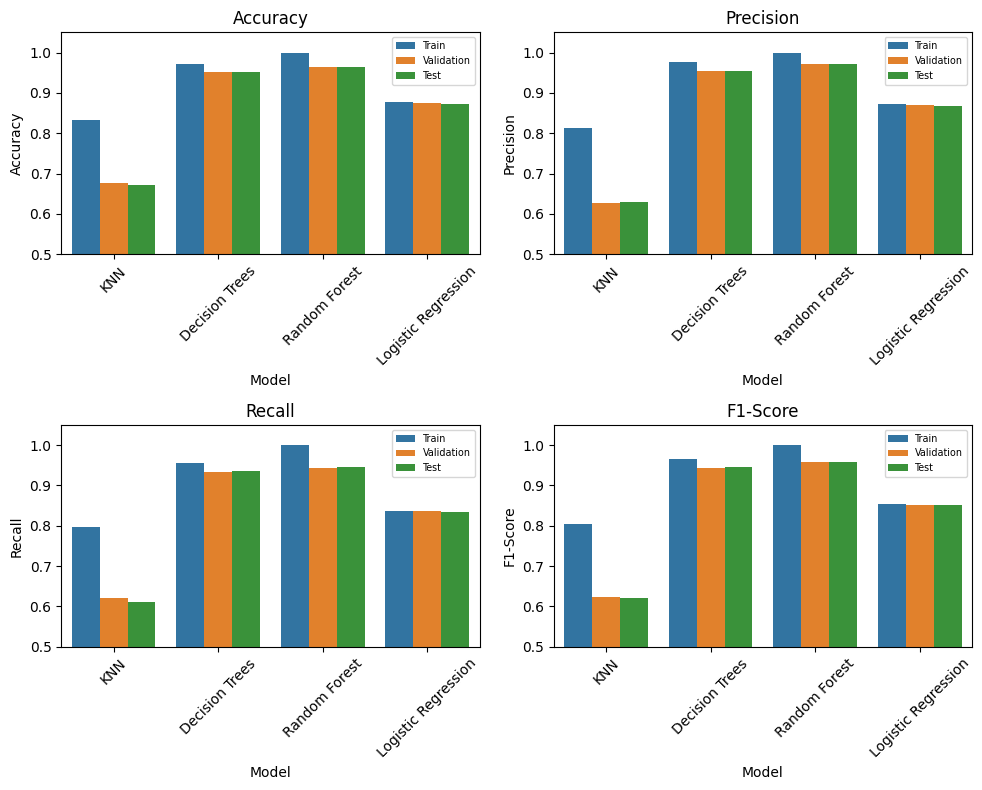

In [217]:
plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
plt.title('Accuracy')
sns.barplot(x='Model', y='Accuracy', data=results, hue='Dataset')
plt.xticks(rotation=45)
plt.ylim(0.5,1.05)
plt.legend(fontsize='x-small', title_fontsize='10')

plt.subplot(2,2,2)
plt.title('Precision')
sns.barplot(x='Model', y='Precision', data=results, hue='Dataset')
plt.xticks(rotation=45)
plt.ylim(0.5,1.05)
plt.legend(fontsize='x-small', title_fontsize='10')

plt.subplot(2,2,3)
plt.title('Recall')
sns.barplot(x='Model', y='Recall', data=results, hue='Dataset')
plt.xticks(rotation=45)
plt.ylim(0.5,1.05)
plt.legend(fontsize='x-small', title_fontsize='10')

plt.subplot(2,2,4)
plt.title('F1-Score')
sns.barplot(x='Model', y='F1-Score', data=results, hue='Dataset')
plt.xticks(rotation=45)
plt.ylim(0.5,1.05)
plt.legend(fontsize='x-small', title_fontsize='10')

plt.tight_layout()